In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx

import matplotlib.pyplot as plt

In [2]:
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 12.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
# Spacy English language model
NER = spacy.load('en_core_web_sm')

## Load Books

In [4]:
import os

# Get all books from directory
all_books = [book for book in os.scandir('data/books') if '.txt' in book.name]

In [5]:
all_books

[<DirEntry 'Book 3 - The Prisoner of Azkaban.txt'>,
 <DirEntry 'Book 7 - The Deathly Hallows.txt'>,
 <DirEntry 'Book 2 - The Chamber of Secrets.txt'>,
 <DirEntry 'Book 4 - The Goblet of Fire.txt'>,
 <DirEntry 'Book 6 - The Half Blood Prince.txt'>,
 <DirEntry "Book 1 - The Philosopher's Stone.txt">,
 <DirEntry 'Book 5 - The Order of the Phoenix.txt'>]

In [6]:
# Grab the first book from all_books
book = all_books[5]

# Open and read the book just as real life :)
book_text = open(book).read()

# Send text to the model
book_doc = NER(book_text)

In [7]:
# Visulize part of a book with entities that catched
displacy.render(book_doc[:200], style='ent', jupyter=True)

## Load character names that we scraped

In [8]:
# Read csv file that we scraped
character_df = pd.read_csv('./data/character_names.csv')

# Clean unnecessary columns
character_df.drop(columns=['Unnamed: 0'],inplace=True)

In [9]:
# Strip data for better matching
character_df.names = character_df.names.str.strip(' ')

In [10]:
character_df.head()

,names,last_name,first_name
0,Euan Abercrombie,Abercrombie,Euan
1,Steward Ackerley,Ackerley,Steward
2,Falcon Aesalon,Aesalon,Falcon
3,Agnes,Agnes,NaN
4,Cornelius Agrippa,Agrippa,Cornelius


## Get named entities per sentences

In [11]:
sent_entity_df = []

# Loop all sentences and save each entity per sentences
for sent in book_doc.sents:
    
    # Get entities found in sentence
    entity_list = [ent.text for ent in sent.ents]
    
    # Save sentences and entities as dictionary
    sent_entity_df.append({'sentence':sent,'entity':entity_list})

sent_entity_df = pd.DataFrame(sent_entity_df)

In [12]:
sent_entity_df.head()

,sentence,entity
0,"(/, \n\n\n\n\n, THE, BOY, WHO, LIVED, \n\n, Mr...","[LIVED, Dursley, number four, Privet Drive]"
1,"(They, were, the, last, people, you, ’d, \n, e...",[]
2,"(Mr., Dursley, was, the, director, of, a, firm...","[Dursley, Grunnings]"
3,"(He, was, a, big, ,, beefy, \n, man, with, har...",[]
4,"(Mrs., Dursley, was, thin, and, \n, blonde, an...",[Dursley]


In [13]:
# Function to filter entities with character names
def filter_entity(entitiy_list, character_df):
    """
    
    This function filters entities for characters in our character_df dataframe.
    
    Parameters:
    entitiy_list -- list of entities found by model
    character_df -- data frame which has all character names
    
    Output:
    a list of entities that are characters (matching by names or first names).
    
    """
    
    return [entity for entity in entitiy_list
            if entity in list(character_df.names.unique())
            or entity in list(character_df.first_name.unique())
    ]

In [14]:
# Apply filter_entity function to our data frame.
sent_entity_df['entity'] = sent_entity_df['entity'].apply(lambda x: filter_entity(x, character_df))

# Filter out sentences with no entities
sent_entity_df_filtered = sent_entity_df[sent_entity_df.entity.map(len)>0]

In [15]:
sent_entity_df_filtered.head()

,sentence,entity
5,"(The, Dursley, s, had, a, small, son, \n, call...",[Dudley]
8,"(Mrs., Potter, was, Mrs., Dursley, ’s, sister,...",[Harry Potter]
11,"(This, boy, was, another, good, reason, for, k...",[Dudley]
13,"(Mr., Dursley, hummed, as, he, picked, out, \n...",[Dudley]
15,"(At, half, past, eight, ,, Mr., Dursley, picke...","[Dudley, Dudley]"


In [16]:
# Filter only for first name (eg. Harry Potter and Harry is same person so they need to appear as same name)
sent_entity_df_filtered['entity'] = sent_entity_df_filtered['entity'].apply(lambda x: [item.split(' ')[0] for item in x])

/var/folders/mx/zffbks614vjg46_y83gtq58w0000gn/T/ipykernel_4912/1327914986.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['entity'] = sent_entity_df_filtered['entity'].apply(lambda x: [item.split(' ')[0] for item in x])


In [17]:
sent_entity_df_filtered.head()

,sentence,entity
5,"(The, Dursley, s, had, a, small, son, \n, call...",[Dudley]
8,"(Mrs., Potter, was, Mrs., Dursley, ’s, sister,...",[Harry]
11,"(This, boy, was, another, good, reason, for, k...",[Dudley]
13,"(Mr., Dursley, hummed, as, he, picked, out, \n...",[Dudley]
15,"(At, half, past, eight, ,, Mr., Dursley, picke...","[Dudley, Dudley]"


## Create relationships

In [18]:
# Window size for reading through a book
window_size = 5

relationships = []

# Loop for reading through book by window size.
for i in range(sent_entity_df_filtered.index[-1]):
    
    # Being sure end index is not exceeds last index that book has
    end_i = min(i+5,sent_entity_df_filtered.index[-1])
    
    # Concatanate entities which appers in same window size
    char_list = sum((sent_entity_df_filtered.loc[i : end_i].entity), [])
    
    # Remove duplicated character which is in same window size (eg. we are not looking for relationship which Harry has with himself)
    char_unique = list(set(char_list))
    
    # Save entities appears next to each other
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx+1]
            relationships.append({'source':a, 'target':b})

In [19]:
# Create data frame for relationships
relationship_df = pd.DataFrame(relationships)

In [20]:
relationship_df.head()

,source,target
0,Harry,Dudley
1,Harry,Dudley
2,Harry,Dudley
3,Harry,Dudley
4,Harry,Dudley


In [21]:
# Clean reversed relationships (eg. Harry -> Dudley and Dudley -> Harry means the same thing)
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis=1), columns = relationship_df.columns)
relationship_df.head()

,source,target
0,Dudley,Harry
1,Dudley,Harry
2,Dudley,Harry
3,Dudley,Harry
4,Dudley,Harry


In [22]:
# Give one point for each appearence
relationship_df['value'] = 1

# Sum all relationships
relationship_df = relationship_df.groupby(['source','target'],sort = False, as_index= False).sum()

In [23]:
relationship_df.head(10)

,source,target,value
0,Dudley,Harry,400
1,Harry,Harvey,5
2,Harold,Harry,5
3,Harold,Harvey,1
4,Harry,Petunia,59
5,Albus,Harry,34
6,James,Lily,7
7,Hagrid,Harry,779
8,Harry,James,11
9,Dudley,Petunia,58


## Analysis and Visualization

In [24]:
# Create graph from pandas dataframe
G = nx.from_pandas_edgelist(relationship_df,
                            source = 'source',
                            target = 'target',
                            edge_attr ='value',
                            create_using = nx.Graph())

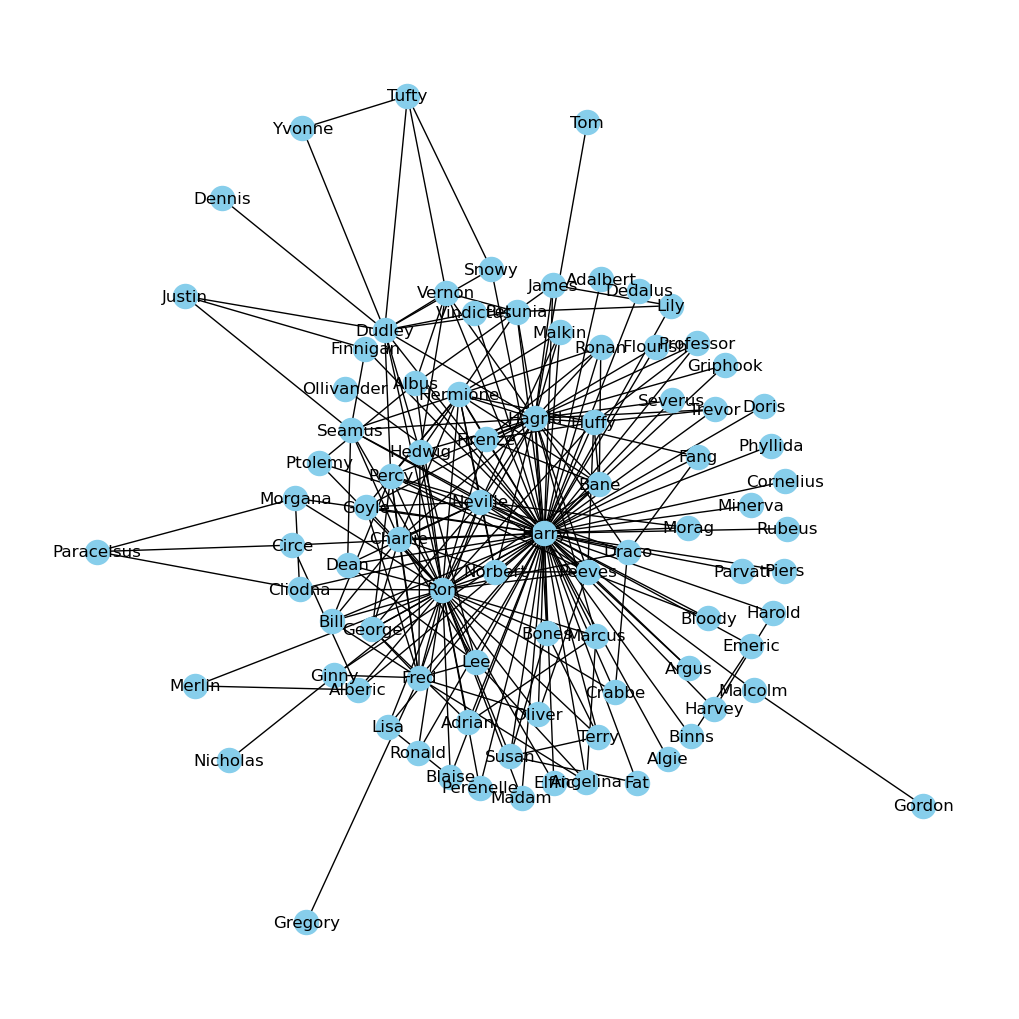

In [25]:
# Visualize graph that we created
plt.figure(figsize= (10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap = plt.cm.Blues, pos = pos)
plt.show()

## Visualization with Pyvis

In [26]:
from pyvis.network import Network
net = Network(notebook=True, width='1000px', height='700px', bgcolor='#222222', font_color = 'white', cdn_resources='in_line')
net.repulsion()

# Setting for node size (more relationship bigger node)
node_degree = dict(G.degree)
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show('harry_potter.html')

harry_potter.html


## The most important Characters

In [27]:
degree_dict = nx.degree_centrality(G)
degree_dict

{'Dudley': 0.14942528735632182,
 'Harry': 0.8850574712643678,
 'Harvey': 0.022988505747126436,
 'Harold': 0.022988505747126436,
 'Petunia': 0.06896551724137931,
 'Albus': 0.05747126436781609,
 'James': 0.04597701149425287,
 'Lily': 0.034482758620689655,
 'Hagrid': 0.3448275862068966,
 'Vernon': 0.08045977011494253,
 'Snowy': 0.034482758620689655,
 'Tufty': 0.04597701149425287,
 'Yvonne': 0.022988505747126436,
 'Piers': 0.011494252873563218,
 'Gordon': 0.011494252873563218,
 'Malcolm': 0.022988505747126436,
 'Dennis': 0.011494252873563218,
 'Rubeus': 0.011494252873563218,
 'Minerva': 0.011494252873563218,
 'Bones': 0.05747126436781609,
 'Cornelius': 0.011494252873563218,
 'Phyllida': 0.011494252873563218,
 'Adalbert': 0.011494252873563218,
 'Tom': 0.011494252873563218,
 'Doris': 0.011494252873563218,
 'Dedalus': 0.011494252873563218,
 'Professor': 0.034482758620689655,
 'Griphook': 0.022988505747126436,
 'Malkin': 0.04597701149425287,
 'Flourish': 0.022988505747126436,
 'Vindictus': 0.0

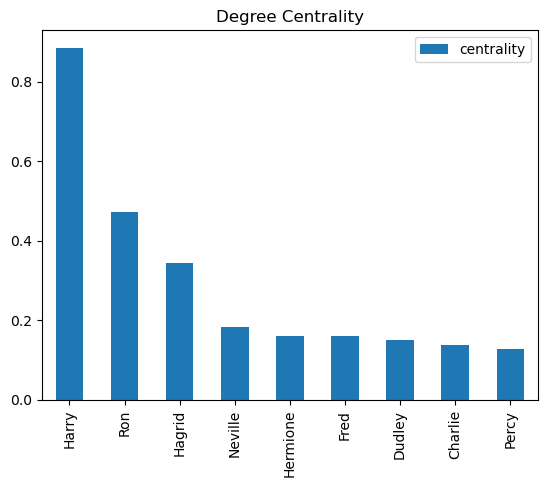

In [28]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns= ['centrality'])

degree_df.sort_values('centrality', ascending=False)[0:9].plot(kind='bar',title='Degree Centrality');

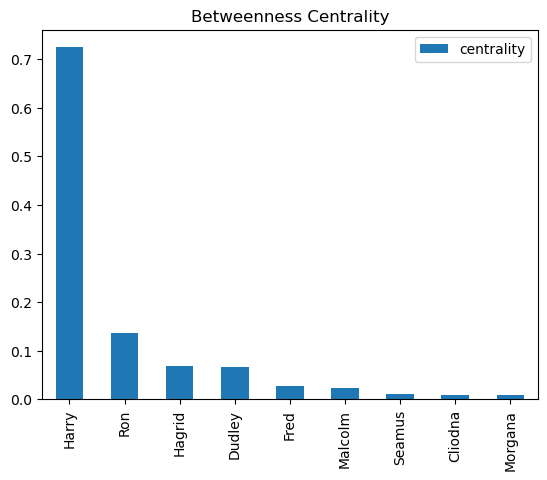

In [29]:
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns= ['centrality'])

betweenness_df.sort_values('centrality', ascending=False)[0:9].plot(kind='bar', title= 'Betweenness Centrality');

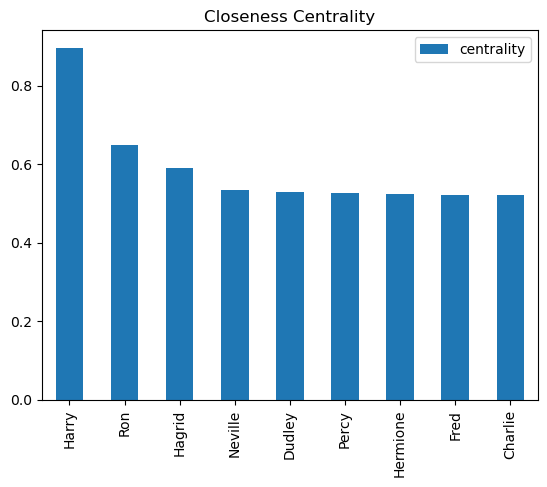

In [30]:
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns= ['centrality'])

closeness_df.sort_values('centrality', ascending=False)[0:9].plot(kind='bar', title='Closeness Centrality');

## Community Detection

In [31]:
from community import community_louvain

In [32]:
# Send graph to community detection algorithm
communities = community_louvain.best_partition(G)

In [33]:
# Set communites as group attribute
nx.set_node_attributes(G, communities, 'group')

In [34]:
# Visualize network
net = Network(notebook=True, width='1000px', height='700px', bgcolor='#222222',font_color = 'white',cdn_resources='in_line')
net.repulsion()

net.from_nx(G)
net.show('harry_potter.html')

harry_potter.html
